# Faster R-CNN with pretrained model using torch

In [98]:
import torchvision
from torchvision.transforms import Compose, ToTensor
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np


Download pretrained model

In [99]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True) 
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Define the class names given by PyTorch’s official docs

In [100]:
COCO_INSTANCE_CATEGORY_NAMES = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [101]:
def get_prediction(img_path, threshold):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
      - threshold - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.
     
  """
  img = Image.open(img_path)
  transform = Compose([ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))] for i in list(pred[0]['boxes'].detach().numpy())]
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class

In [102]:
def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3): 
    boxes, pred_cls = get_prediction(img_path, threshold) 
    # Get predictions 
    img = cv2.imread(img_path) 
    # Read image with cv2 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    # Convert to RGB 
    for i in range(len(boxes)): 
        img = cv2.rectangle(img, boxes[i][0], boxes[i][1], color=(0, 255, 0), thickness=rect_th) 
        # Draw Rectangle with the coordinates 
        img = cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)      
    plt.xticks([]) 
    plt.yticks([]) 
    plt.imshow(img)

Inference

In [103]:
import requests


In [104]:
image_url = 'https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg'
img_data = requests.get(image_url).content
with open('people.jpg', 'wb') as handler:
    handler.write(img_data)

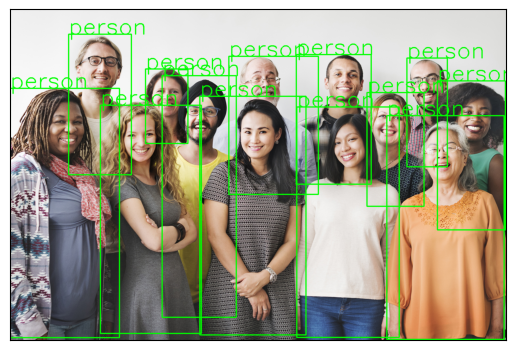

In [105]:
object_detection_api('./people.jpg', threshold=0.8)